In [3]:
import urllib.request, json 
import re
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt 
import pyLDAvis
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
pd.options.mode.chained_assignment = None

In [402]:
newspapers_ids_bn = pd.read_csv('bln-newspapers-ids.csv')
newspaper_loc_bn = pd.read_csv('bln-places.csv')

In [521]:
import urllib.parse
level = "ARTICLE"
date = "[18910000 TO 19000000]"
art_type = "Classified ads"
offset = "0"
limit = "-1"
word= "pills"
query = "<"+level+"§articleType:\""+art_type+"\" AND dateStart:"+date+ " AND " +word+"§"+level+">"
query = urllib.parse.quote(query)
#url = "https://vm0824.kaj.pouta.csc.fi/octavo/bln1800/search??pretty&fieldEnricher=&offsetDataConverter=&query="
url = "https://vm0824.kaj.pouta.csc.fi/octavo/bln1800/queryStats?query="
url += query
url+= "&field=newspaperID&maxDocs=-1"
#url += "&field=newspaperID&field=ocrConfidence&field=text&field=title&offset="+offset
#url += "&limit="+limit
#url += "&snippetLimit=0&contextLevel=Sentence&contextExpandLeft=0&contextExpandRight=0&level=&endpoint=https%3A%2F%2Fvm0824.kaj.pouta.csc.fi%2Foctavo%2Fbln1800%2F"
print(url)

https://vm0824.kaj.pouta.csc.fi/octavo/bln1800/queryStats?query=%3CARTICLE%C2%A7articleType%3A%22Classified%20ads%22%20AND%20dateStart%3A%5B18910000%20TO%2019000000%5D%20AND%20pills%C2%A7ARTICLE%3E&field=newspaperID&maxDocs=-1


In [522]:
with urllib.request.urlopen(url) as url:
    data = json.loads(url.read().decode())

In [523]:
total_papers = len(data['results']['grouped'])

In [524]:
#test 
new_retrieve_data = []

for k in range(total_papers):
    paper_name = []
    paper_city = []
    newspaper_id = data['results']['grouped'][k]['fields']['newspaperID']
    total_term_freq = data['results']['grouped'][k]['stats']
    word_pills_freq= total_term_freq['totalTermFreq'] - total_term_freq['docFreq'] - total_term_freq['docFreq']
    word_pills_ratio = round(word_pills_freq/total_term_freq['docFreq'], 2)
    index_paper_id = newspapers_ids_bn[newspapers_ids_bn['id2s'].str.split(',').apply(lambda numbers: newspaper_id in numbers)]
    paper_name_index = index_paper_id['newspaper'].values
    for jj in range(0, len(paper_name_index)):
        paper_name.append(paper_name_index[jj])
    for p in paper_name:
        index_paper_loc = newspaper_loc_bn[newspaper_loc_bn['Publication Title'] == p]
        paper_city_ind = index_paper_loc['City'].values
        for ii in range(0, len(paper_city_ind)):
            paper_city.append(paper_city_ind[ii])
    
    new_retrieve_data.append([newspaper_id, paper_name,paper_city,word_pills_freq, word_pills_ratio])

In [525]:
word_freq_loc = pd.DataFrame(new_retrieve_data, columns=['NewspaperID', 'NewspaperName', 'Location', 'WordFreq', 'WordRatio'])

In [526]:
word_freq_loc['Location'] = word_freq_loc.Location.apply(lambda x: ', '.join([str(i) for i in x]))

In [527]:
word_freq_loc['NewspaperName'] = word_freq_loc.NewspaperName.apply(lambda x: ', '.join([str(i) for i in x]))

In [9]:
data_1800_1810.head()

,NewspaperID,NewspaperName,Location,WordFreq,WordRatio
0,BNCN0071,Morning Chronicle,London,1529,2.05
1,BNCN0014,Derby Mercury,Derby,2344,3.38
2,NCBL0117,Morning Post,London,1062,1.87
3,BNCN0026,Jackson's Oxford Journal,Oxford,1351,2.86
4,BNCN0024,The Ipswich Journal,Ipswich,1078,2.32


In [529]:
word_freq_loc.to_pickle('./data_location/1891-1900.pkl')

In [6]:
data_1800_1810 = pd.read_pickle('./data_location/1800-1810.pkl')

In [7]:
papers_1800_1810 = data_1800_1810.groupby('NewspaperName', as_index=False)[['WordFreq', 'WordRatio']].sum()
cities_1800_1810 = data_1800_1810.groupby('Location', as_index=False)[['WordFreq', 'WordRatio']].mean()

In [582]:
pills_1800_1810 = data_1800_1810['WordFreq'].sum()


In [555]:
test_url = 'https://vm0824.kaj.pouta.csc.fi/octavo/bln1800/search??pretty&fieldEnricher=&offsetDataConverter=&query=%3CARTICLE%C2%A7articleType%3A%22Classified%20ads%22%20AND%20dateStart%3A%20%5B18000000%20TO%2018100000%5D%C2%A7ARTICLE%3E&field=length&offset=0&limit=20&snippetLimit=0&contextLevel=Sentence&contextExpandLeft=0&contextExpandRight=0&level=&endpoint=https%3A%2F%2Fvm0824.kaj.pouta.csc.fi%2Foctavo%2Fbln1800%2F&sortContextLevel=Word&sortContextDistance=0&sortContextDistance=-1&sortContextDistance=1&sortContextDirection=A&sortContextDirection=A&sortContextDirection=A'

In [557]:
with urllib.request.urlopen(test_url) as url:
    data_total_words = json.loads(url.read().decode())

In [556]:
#papers_1800_1810.sort_values('WordFreq', ascending=False)

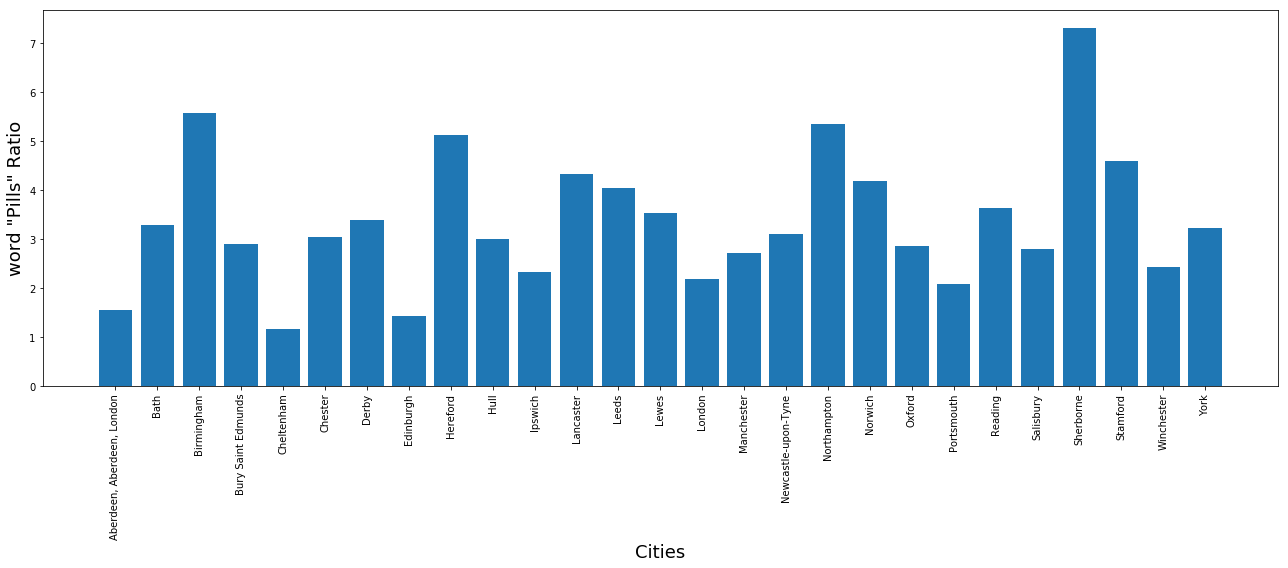

In [14]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(cities_1800_1810['Location'], cities_1800_1810['WordRatio'])
plt.xticks(rotation=90)
plt.xlabel('Cities', fontsize=18)
plt.ylabel('word "Pills" Ratio', fontsize=18)
plt.tight_layout()
plt.show()

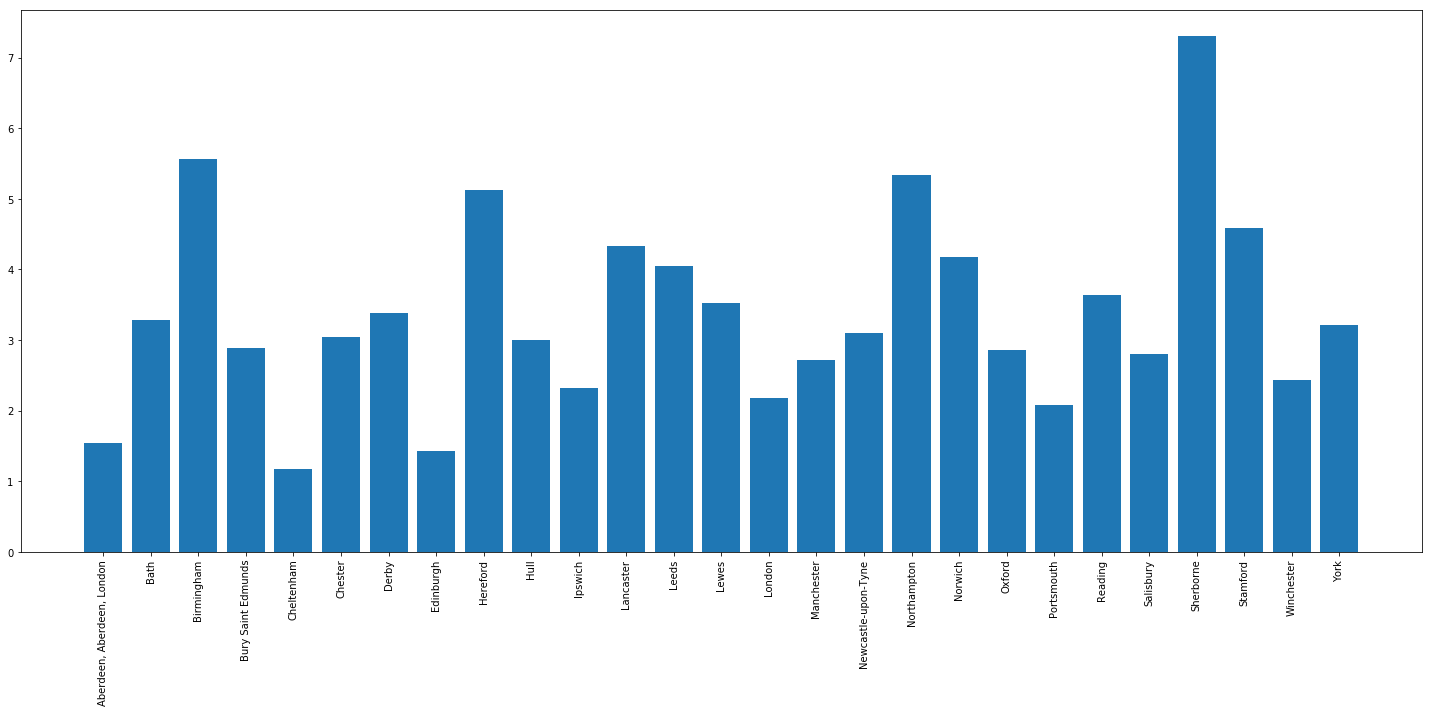

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(cities_1800_1810['Location'], cities_1800_1810['WordRatio'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

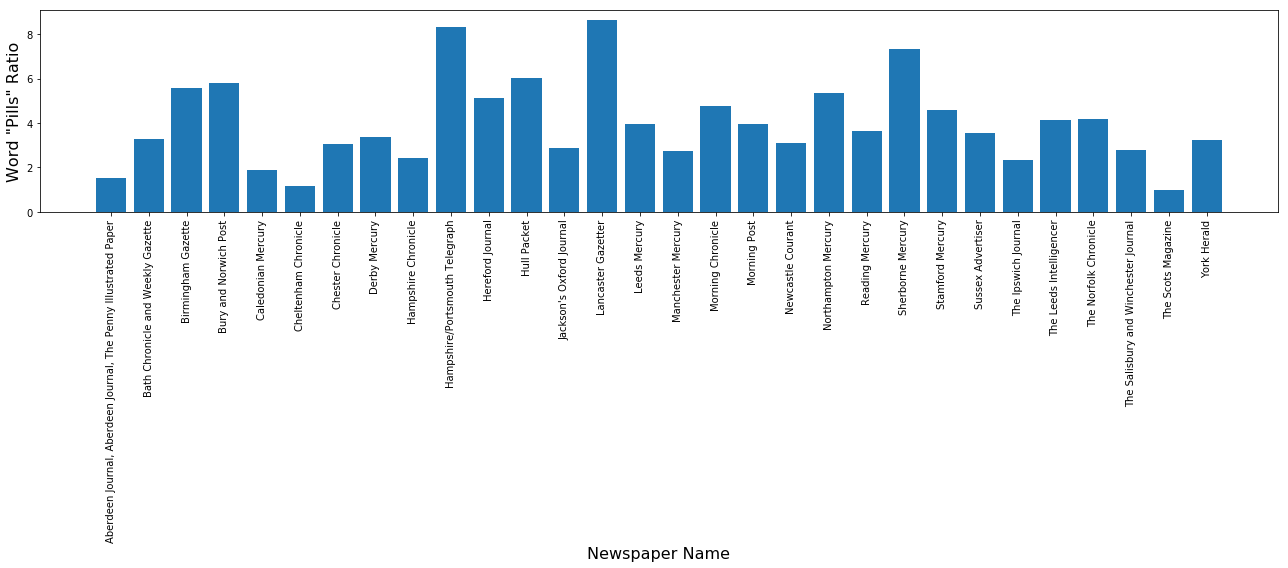

In [17]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(papers_1800_1810['NewspaperName'], papers_1800_1810['WordRatio'])
plt.xticks(rotation=90)
plt.xlabel('Newspaper Name', fontsize = 16)
plt.ylabel('Word "Pills" Ratio', fontsize = 16)
plt.tight_layout()
plt.show()

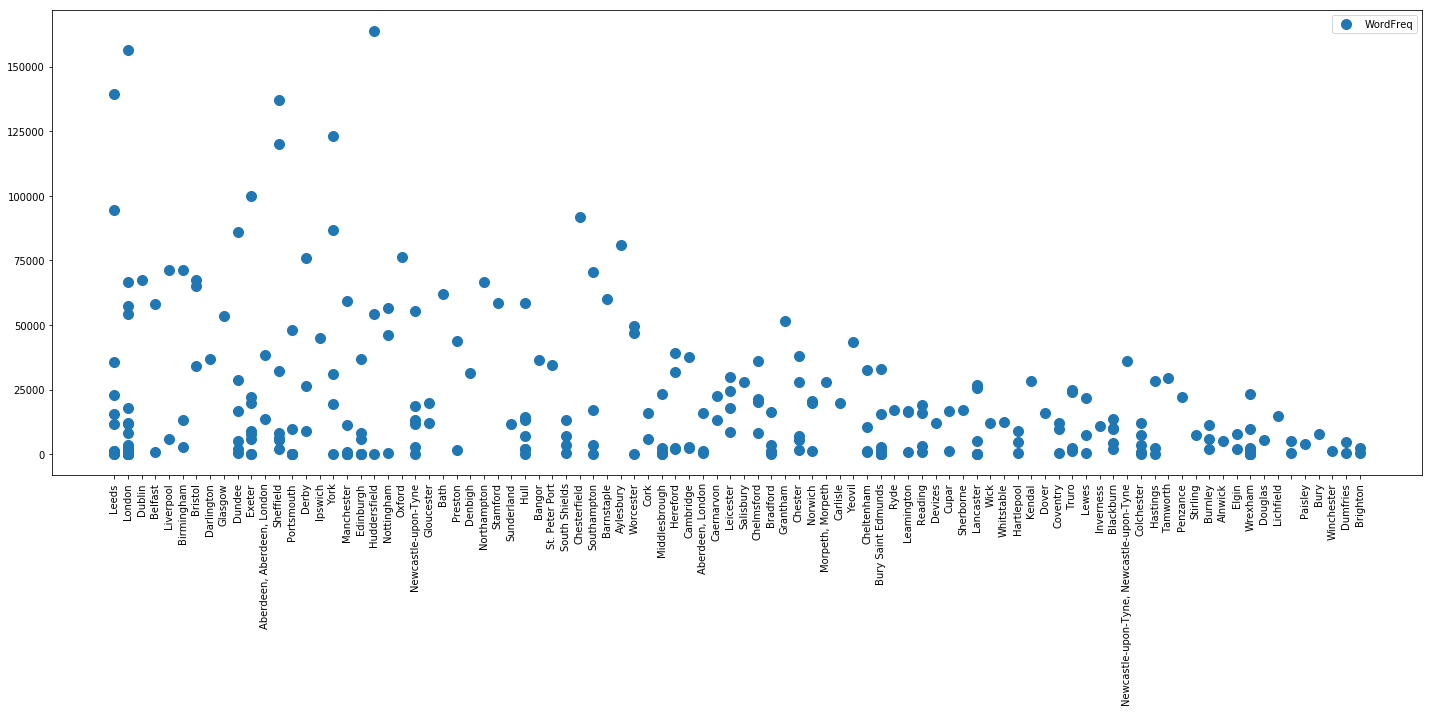

In [418]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(word_freq_loc['Location'], word_freq_loc['WordFreq'], s=10**2, marker="o")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [419]:
word_freq_loc = word_freq_loc.sort_values('WordFreq', ascending=False)

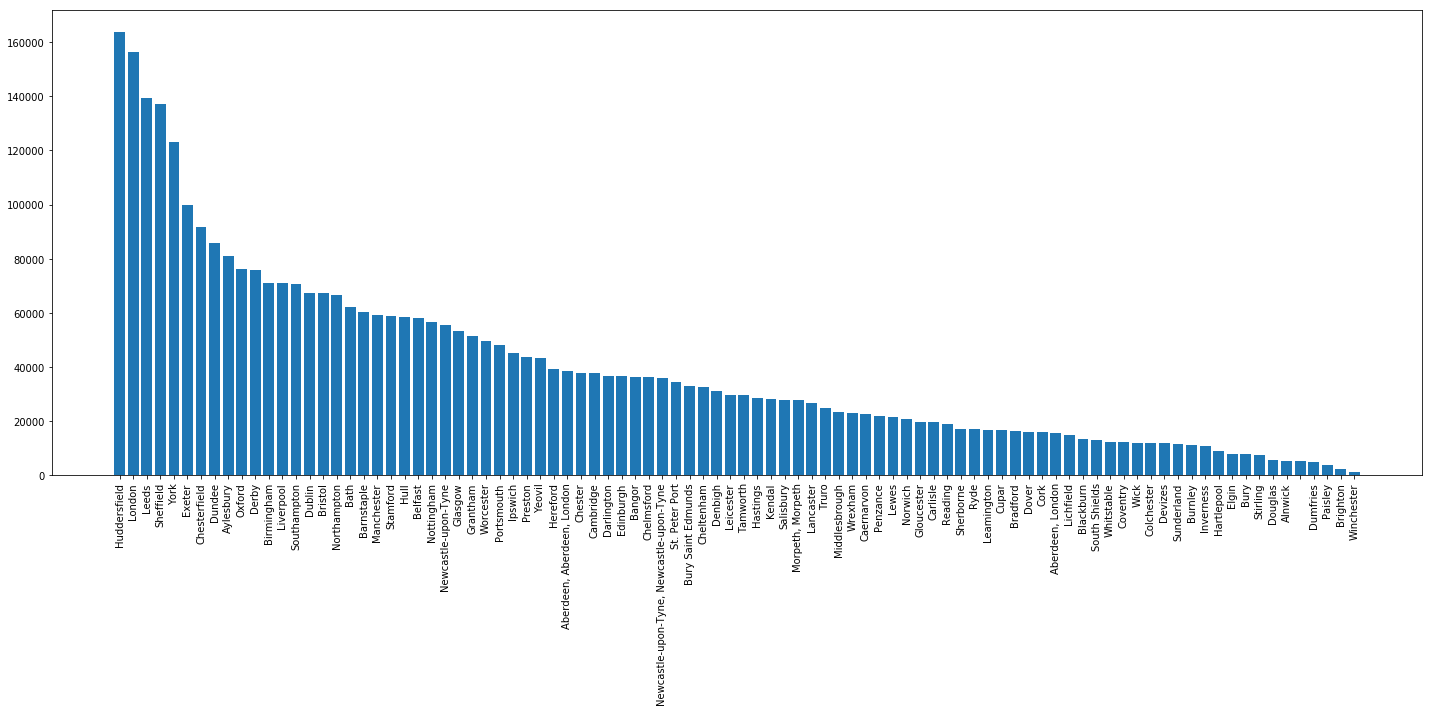

In [420]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(word_freq_loc['Location'], word_freq_loc['WordFreq'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [421]:
new_word_freq_loc = word_freq_loc.groupby('Location', as_index=False)[['WordFreq']].sum()

In [434]:
issue_test = word_freq_loc.groupby('Location', as_index=False)[['NewspaperName']].count()

In [438]:
issue_test = issue_test.sort_values('NewspaperName', ascending=False)
issue_test.head()

,Location,NewspaperName
58,London,24
89,Wrexham,12
16,Bury Saint Edmunds,11
53,Leeds,10
39,Exeter,8


In [424]:
new_word_freq_loc = new_word_freq_loc.sort_values('WordFreq', ascending=False)
new_word_freq_loc.head()

,Location,WordFreq
58,London,398459
53,Leeds,322922
75,Sheffield,311267
91,York,260036
46,Huddersfield,218126


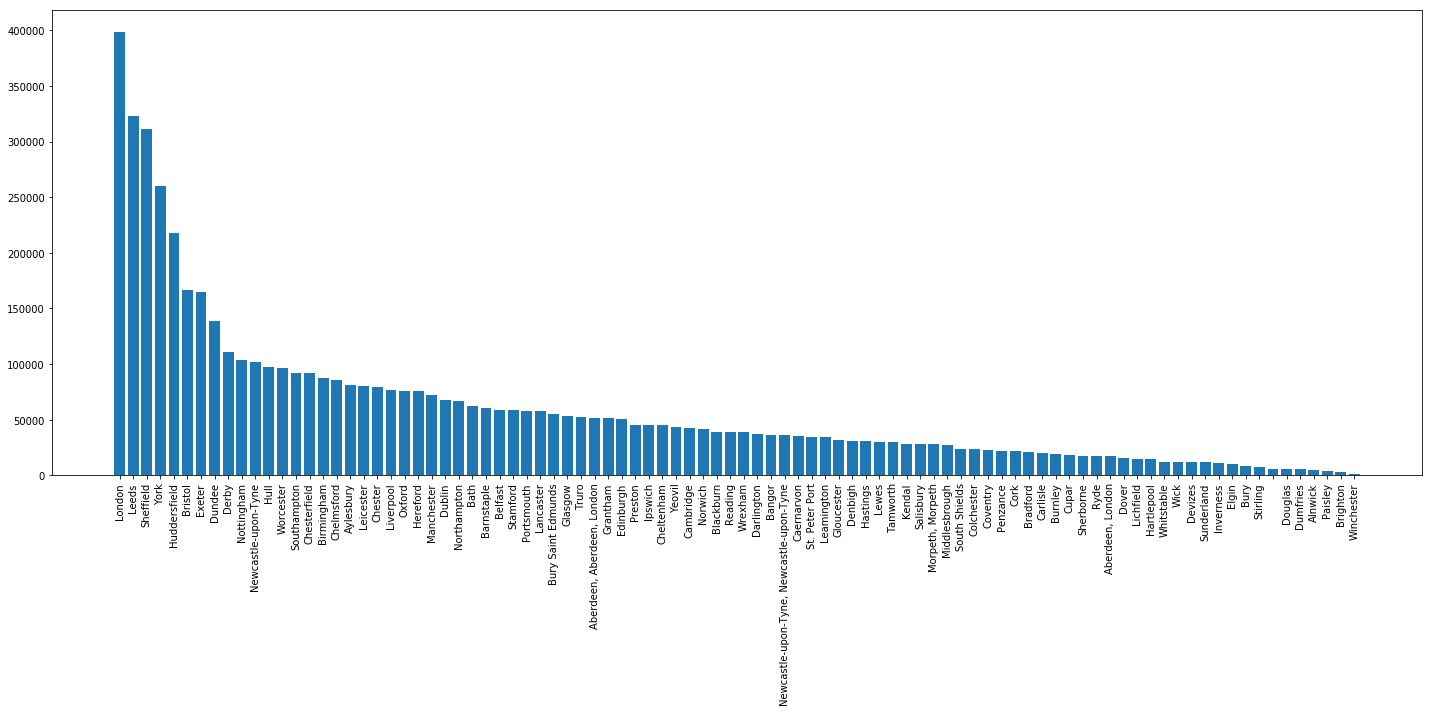

In [1000]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(new_word_freq_loc['Location'], new_word_freq_loc['WordFreq'])
plt.xticks(rotation=90)
#ax.set_yscale("log")
plt.tight_layout()
plt.show()

In [571]:
#newspaper_id = 'BNCN0071'
level = "ARTICLE"
date = "[18000000 TO 18100000]"
art_type = "Classified ads"
offset = "0"
limit = "-1"
query = "<"+level+"§articleType:\""+art_type+"\" AND dateStart:"+date+"§"+level+">"
#query = "<"+level+"§articleType:\""+art_type+"\" AND dateStart:"+date+" AND newspaperID:\""+newspaper_id+"\" AND "+ word+"§"+level+">" 
query = urllib.parse.quote(query)
url2 = "https://vm0824.kaj.pouta.csc.fi/octavo/bln1800/search??pretty&fieldEnricher=&offsetDataConverter=&query="
url2 += query
#url += "&field=newspaperID&field=ocrConfidence&field=text&field=title&offset="+offset
#url2 += "&field=ocrConfidence&field=text&field=title&offset="+offset
url2 += "&field=length"
url2 += "&limit="+limit
url2 += "&snippetLimit=0&contextLevel=Sentence&contextExpandLeft=0&contextExpandRight=0&level=&endpoint=https%3A%2F%2Fvm0824.kaj.pouta.csc.fi%2Foctavo%2Fbln1800%2F"
print(url2)

https://vm0824.kaj.pouta.csc.fi/octavo/bln1800/search??pretty&fieldEnricher=&offsetDataConverter=&query=%3CARTICLE%C2%A7articleType%3A%22Classified%20ads%22%20AND%20dateStart%3A%5B18000000%20TO%2018100000%5D%C2%A7ARTICLE%3E&field=length&limit=-1&snippetLimit=0&contextLevel=Sentence&contextExpandLeft=0&contextExpandRight=0&level=&endpoint=https%3A%2F%2Fvm0824.kaj.pouta.csc.fi%2Foctavo%2Fbln1800%2F


In [572]:
with urllib.request.urlopen(url2) as url:
    data2 = json.loads(url.read().decode())

In [574]:
total_docs = len(data2['results']['docs'])

In [578]:
total_words = 0
for q in range(total_docs):
    total_words+= data2['results']['docs'][q]['length']

In [366]:
url_test = 'https://vm0824.kaj.pouta.csc.fi/octavo/bln1800/search??pretty&fieldEnricher=&offsetDataConverter=&query=%3CARTICLE%C2%A7articleType%3A%22Classified%20ads%22%20AND%20newspaperID%3A%20%22NCBL0145%22%C2%A7ARTICLE%3E&offset=0&limit=20&snippetLimit=-1&contextLevel=Paragraph&contextExpandLeft=0&contextExpandRight=0&level=&endpoint=https%3A%2F%2Fvm0824.kaj.pouta.csc.fi%2Foctavo%2Fbln1800%2F&sortContextLevel=Word&sortContextDistance=0&sortContextDistance=-1&sortContextDistance=1&sortContextDirection=A&sortContextDirection=A&sortContextDirection=A'

In [367]:
with urllib.request.urlopen(url_test) as url:
    data_test = json.loads(url.read().decode())

In [368]:
data_test.keys()

dict_keys(['queryMetadata', 'results'])

In [391]:
test_string = word_tokenize(str(test_string).lower())

In [721]:
data_1800_1810 = pd.read_pickle('./data_location/1800-1810.pkl')

In [722]:
pills_1800_1810 = data_1800_1810['WordFreq'].sum()


In [723]:
pills_1800_1810 = pills_1800_1810*5

In [760]:
#newspaper_id = 'BNCN0071'
level = "ARTICLE"
date = "[18000000 TO 18100000]"
art_type = "News"
offset = "0"
limit = "-1"
query = "<"+level+"§articleType:\""+art_type+"\" AND dateStart:"+date+"§"+level+">"
#query = "<"+level+"§articleType:\""+art_type+"\" AND dateStart:"+date+" AND newspaperID:\""+newspaper_id+"\" AND "+ word+"§"+level+">" 
query = urllib.parse.quote(query)
url2 = "https://vm0824.kaj.pouta.csc.fi/octavo/bln1800/search??pretty&fieldEnricher=&offsetDataConverter=&query="
url2 += query
#url += "&field=newspaperID&field=ocrConfidence&field=text&field=title&offset="+offset
#url2 += "&field=ocrConfidence&field=text&field=title&offset="+offset
url2 += "&field=length"
url2 += "&limit="+limit
url2 += "&snippetLimit=0&contextLevel=Sentence&contextExpandLeft=0&contextExpandRight=0&level=&endpoint=https%3A%2F%2Fvm0824.kaj.pouta.csc.fi%2Foctavo%2Fbln1800%2F"
print(url2)

https://vm0824.kaj.pouta.csc.fi/octavo/bln1800/search??pretty&fieldEnricher=&offsetDataConverter=&query=%3CARTICLE%C2%A7articleType%3A%22News%22%20AND%20dateStart%3A%5B18000000%20TO%2018100000%5D%C2%A7ARTICLE%3E&field=length&limit=-1&snippetLimit=0&contextLevel=Sentence&contextExpandLeft=0&contextExpandRight=0&level=&endpoint=https%3A%2F%2Fvm0824.kaj.pouta.csc.fi%2Foctavo%2Fbln1800%2F


In [761]:
with urllib.request.urlopen(url2) as url:
    data2 = json.loads(url.read().decode())

In [766]:
total_docs = len(data2['results']['docs'])
total_words = 0
for q in range(total_docs):
    total_words+= data2['results']['docs'][q]['length']

In [767]:
pill_ratio = round(pills_1800_1810/total_words,5)

In [729]:
decade = 1900

In [730]:
total_pills_ratio.append([decade,total_words, pills_1800_1810, pill_ratio])

In [732]:
pills_freq_ratio = pd.DataFrame(total_pills_ratio, columns=['Decade', 'Total_Words', 'Word_Pills', 'Pills_Ratio'])

In [998]:
pills_freq_ratio.to_csv('word_pills_across_time.csv', index=False)

In [ ]:
ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, explode=explode)


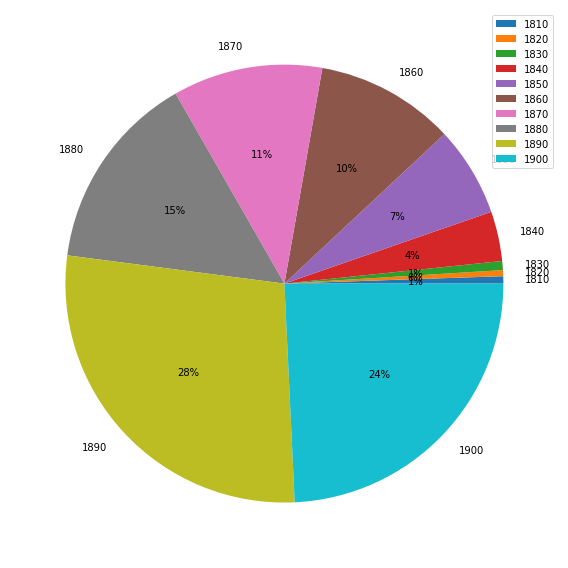

In [751]:
fig, ax = plt.subplots(figsize=(16, 8))
labels = pills_freq_ratio['Decade']
ax.pie(pills_freq_ratio['Word_Pills'], labels=labels,autopct='%1.0f%%')

plt.legend()
#ax.set_yscale("log")
plt.tight_layout()
plt.show()

In [920]:
news_data_1800_1810 = pd.read_pickle('./data_location_news/1900.pkl')
pills_1800_1810 = news_data_1800_1810['WordFreq'].sum()
pills_1800_1810 = pills_1800_1810*5

In [921]:
decade = 1900
level = "ARTICLE"
date = "[18910000 TO 19000000]"
art_type = "News"
offset = "0"
limit = "-1"
query = "<"+level+"§articleType:\""+art_type+"\" AND dateStart:"+date+"§"+level+">"
#query = "<"+level+"§articleType:\""+art_type+"\" AND dateStart:"+date+" AND newspaperID:\""+newspaper_id+"\" AND "+ word+"§"+level+">" 
query = urllib.parse.quote(query)
url2 = "https://vm0824.kaj.pouta.csc.fi/octavo/bln1800/search??pretty&fieldEnricher=&offsetDataConverter=&query="
url2 += query
#url += "&field=newspaperID&field=ocrConfidence&field=text&field=title&offset="+offset
#url2 += "&field=ocrConfidence&field=text&field=title&offset="+offset
url2 += "&field=length"
url2 += "&limit="+limit
url2 += "&snippetLimit=0&contextLevel=Sentence&contextExpandLeft=0&contextExpandRight=0&level=&endpoint=https%3A%2F%2Fvm0824.kaj.pouta.csc.fi%2Foctavo%2Fbln1800%2F"
print(url2)

https://vm0824.kaj.pouta.csc.fi/octavo/bln1800/search??pretty&fieldEnricher=&offsetDataConverter=&query=%3CARTICLE%C2%A7articleType%3A%22News%22%20AND%20dateStart%3A%5B18910000%20TO%2019000000%5D%C2%A7ARTICLE%3E&field=length&limit=-1&snippetLimit=0&contextLevel=Sentence&contextExpandLeft=0&contextExpandRight=0&level=&endpoint=https%3A%2F%2Fvm0824.kaj.pouta.csc.fi%2Foctavo%2Fbln1800%2F


In [922]:
with urllib.request.urlopen(url2) as url:
    data2 = json.loads(url.read().decode())

In [923]:
total_docs = len(data2['results']['docs'])
total_words = 0
for q in range(total_docs):
    total_words+= data2['results']['docs'][q]['length']

In [924]:
news_pill_ratio = round(pills_1800_1810/total_words,5)


In [925]:
total_pills_ratio_news.append([decade,total_words, pills_1800_1810, news_pill_ratio])

In [928]:
news_pills_freq_ratio = pd.DataFrame(total_pills_ratio_news, columns=['Decade', 'Total_Words', 'Word_Pills', 'Pills_Ratio'])

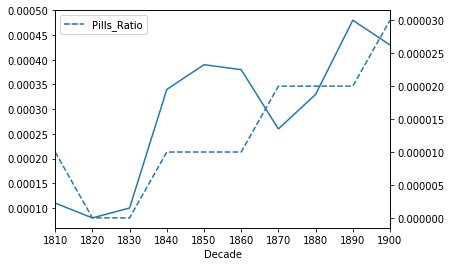

In [957]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

pills_freq_ratio.plot(x = 'Decade',y='Pills_Ratio', ax=ax, ls="-")
news_pills_freq_ratio.plot(x = 'Decade',y='Pills_Ratio', ax=ax2, ls="--")

plt.show()

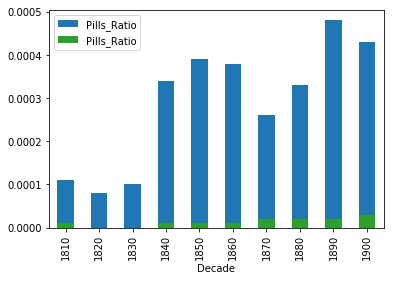

In [967]:
ax = pills_freq_ratio.plot(x="Decade", y="Pills_Ratio", kind="bar")
news_pills_freq_ratio.plot(x="Decade", y="Pills_Ratio", kind="bar", ax=ax, color="C2")


plt.show()

In [978]:

news_pills_freq_ratio = news_pills_freq_ratio.rename(columns={'Pills_Ratio': 'News_Pills_Ratio', 'class_ads_pills': 'Class_Ads_Pills_Ratio'})

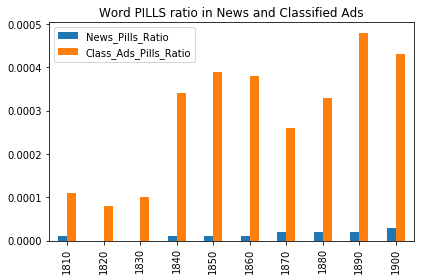

In [992]:
ax = news_pills_freq_ratio[['News_Pills_Ratio', 'Class_Ads_Pills_Ratio']].plot(kind='bar', title = 'Word PILLS ratio in News and Classified Ads')
ax.set_xticklabels(news_pills_freq_ratio.Decade)

plt.savefig('Pills_Ratio_News_Classified_Ads.png')
plt.tight_layout()
plt.show()